# Homework 2 — Task 1: Decision Tree + Sensitivity Analysis (Bank Marketing)



---



1. Load the Bank Marketing dataset
2. Preprocess (train/test split + one-hot encoding)
3. Train 3 different decision trees
4. Visualize each tree and comment on complexity
5. Sensitivity analysis on 2 input features (One-at-a-Time perturbations + optional permutation importance / PDP)

### References
- Decision tree visualization in scikit-learn: `sklearn.tree.plot_tree` (docs)  
  https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html  
- Decision trees overview (scikit-learn user guide)  
  https://scikit-learn.org/stable/modules/tree.html  
- Sensitivity analysis (OAT definition and common practice), Saltelli lecture notes (PDF)  
  https://www.andreasaltelli.eu/file/repository/Saltelli_Lesson_Sens_Analysis_3.pdf  
- Permutation feature importance (model inspection)  
  https://scikit-learn.org/stable/modules/permutation_importance.html  
- Partial dependence / ICE (model inspection)  
  https://scikit-learn.org/stable/modules/partial_dependence.html



In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance, PartialDependenceDisplay

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Load data



In [2]:
!wget -q -O bank_marketing.zip https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
!unzip -o bank_marketing.zip -d .
!unzip -o bank.zip


import pandas as pd

df = pd.read_csv("bank-full.csv", sep=";")

print("Shape:", df.shape)
df.head()


Archive:  bank_marketing.zip
 extracting: ./bank.zip              
 extracting: ./bank-additional.zip   
Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                
Shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## 2. Preprocess



In [3]:
# Target encoding
target_col = "y"
y = (df[target_col].astype(str).str.lower() == "yes").astype(int)

X = df.drop(columns=[target_col]).copy()

# Identify categorical vs numeric columns
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Preprocessor: one-hot encode categoricals, passthrough numerics
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)
d
preprocess


Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numeric columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'poutcome']),
                                ('num', 'passthrough',
                                 ['age', 'balance', 'day', 'duration',
                                  'campaign', 'pdays', 'previous'])])

## 3. Train three decision trees with different parameter settings


Below are three common knobs:
- `max_depth` (caps depth)
- `min_samples_leaf` (forces leaves to have more data)
- `ccp_alpha` (post-pruning via cost-complexity pruning)




In [4]:
tree_configs = {
    "Tree A (shallow)": dict(max_depth=3, random_state=RANDOM_STATE),
    "Tree B (medium)": dict(max_depth=6, min_samples_leaf=20, random_state=RANDOM_STATE),
    "Tree C (less regularized / deeper)": dict(max_depth=None, min_samples_leaf=5, random_state=RANDOM_STATE),
}

models = {}

for name, params in tree_configs.items():
    clf = DecisionTreeClassifier(**params)
    pipe = Pipeline([
        ("prep", preprocess),
        ("model", clf),
    ])
    pipe.fit(X_train, y_train)
    models[name] = pipe

    y_pred = pipe.predict(X_test)
    print(f"\n{name}")
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
    print("Precision:", round(precision_score(y_test, y_pred, zero_division=0), 4))
    print("Recall:", round(recall_score(y_test, y_pred, zero_division=0), 4))
    print("F1:", round(f1_score(y_test, y_pred, zero_division=0), 4))




Tree A (shallow)
Accuracy: 0.8997
Precision: 0.6295
Recall: 0.3469
F1: 0.4473

Tree B (medium)
Accuracy: 0.901
Precision: 0.61
Recall: 0.4272
F1: 0.5025

Tree C (less regularized / deeper)
Accuracy: 0.8884
Precision: 0.5271
Recall: 0.4509
F1: 0.486


## 4. Visualize each tree




=== Tree A (shallow) ===


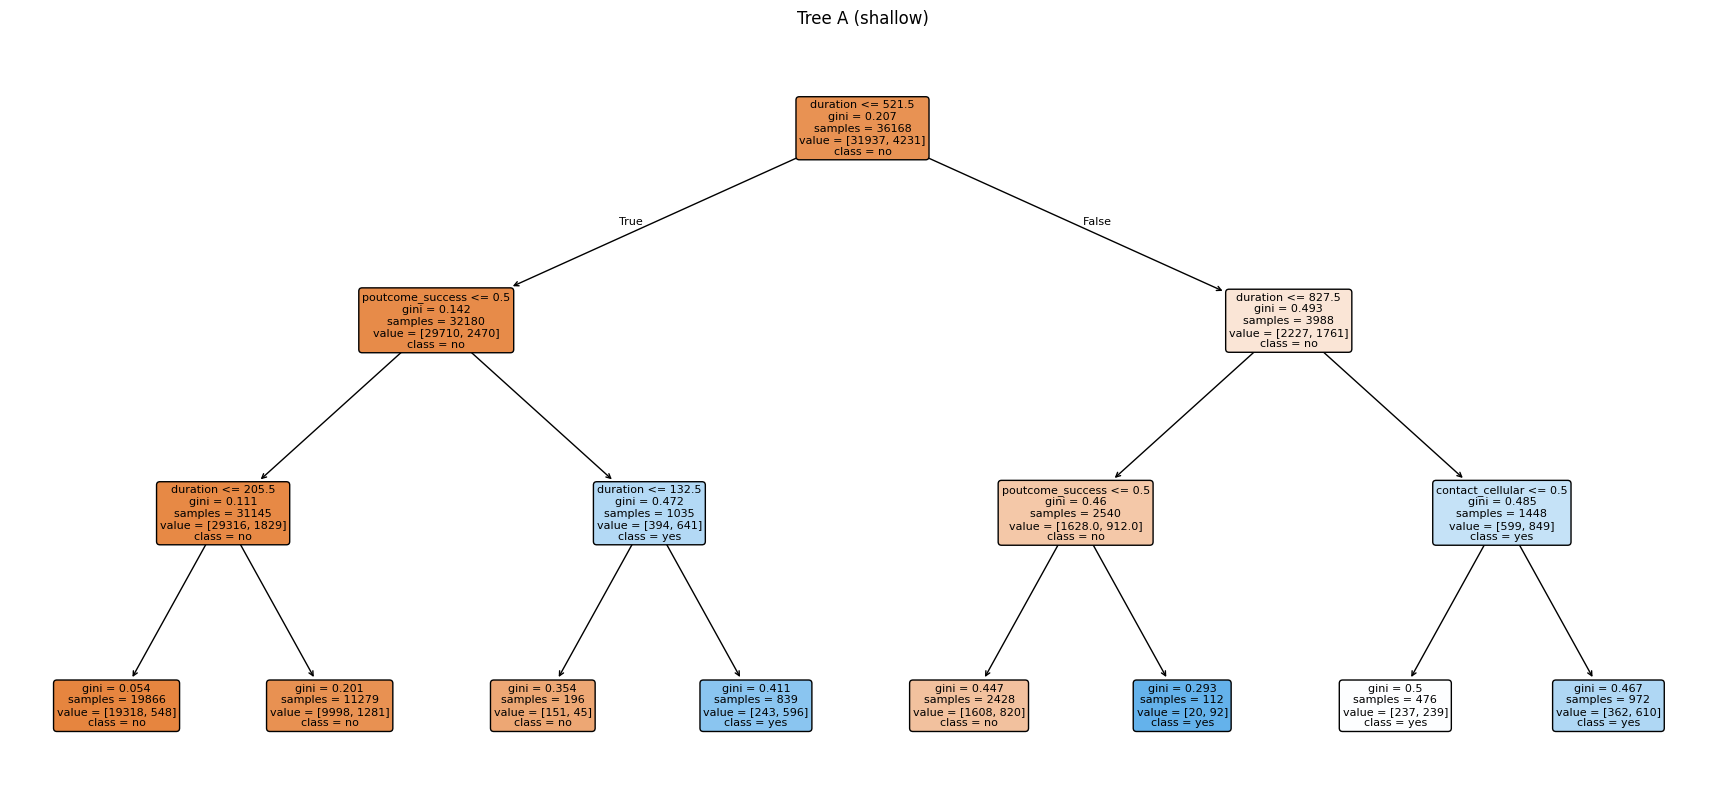

Depth: 3 | Leaves: 8 | Nodes: 15

=== Tree B (medium) ===


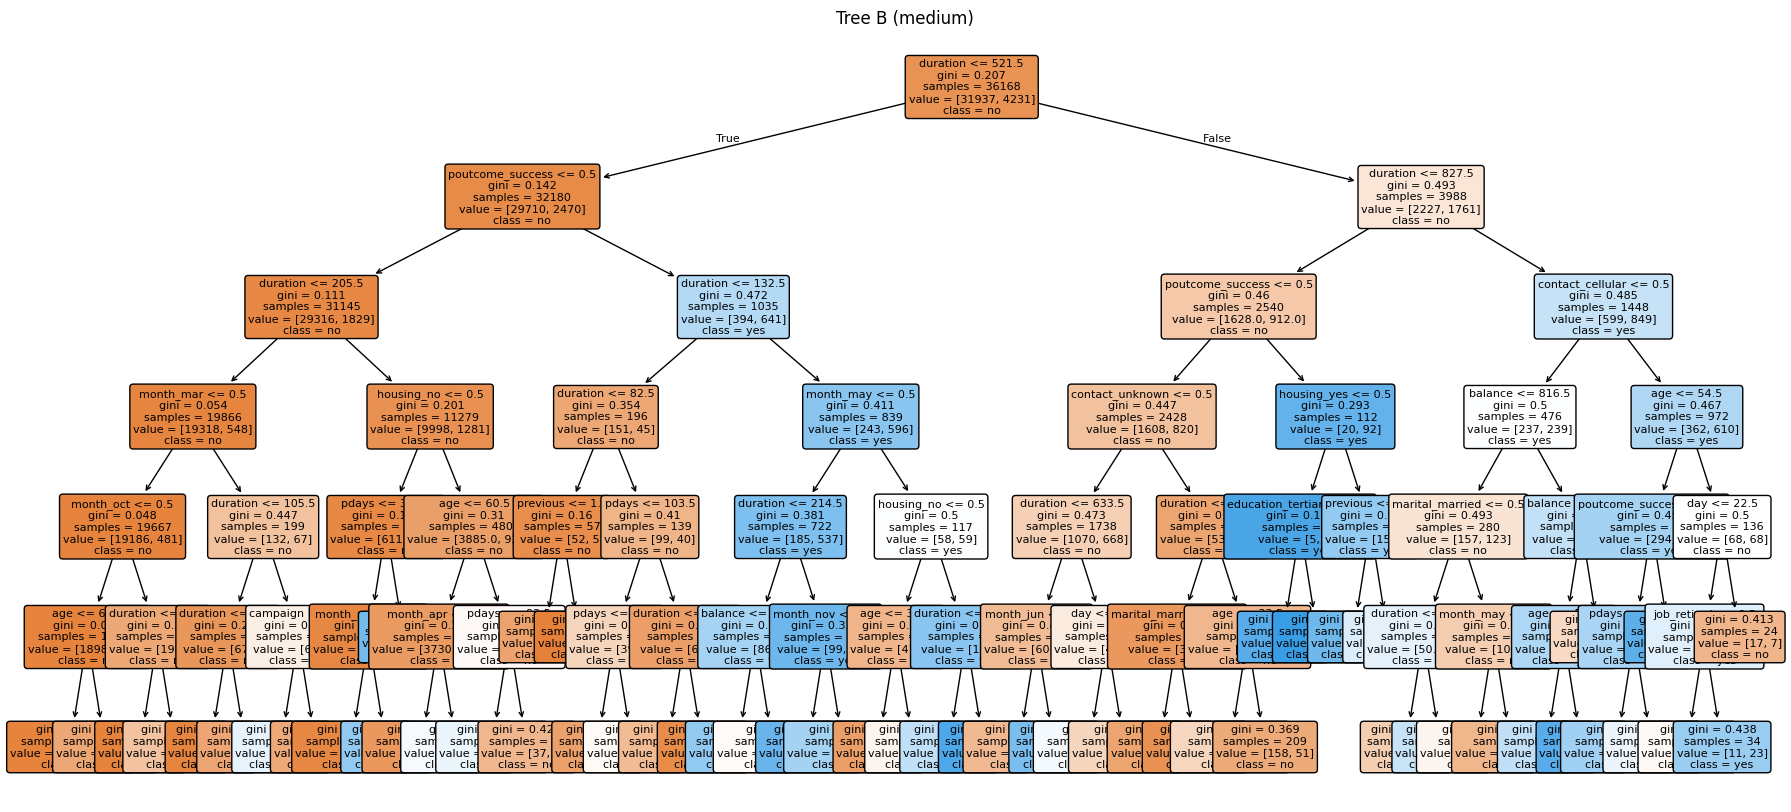

Depth: 6 | Leaves: 54 | Nodes: 107

=== Tree C (less regularized / deeper) ===


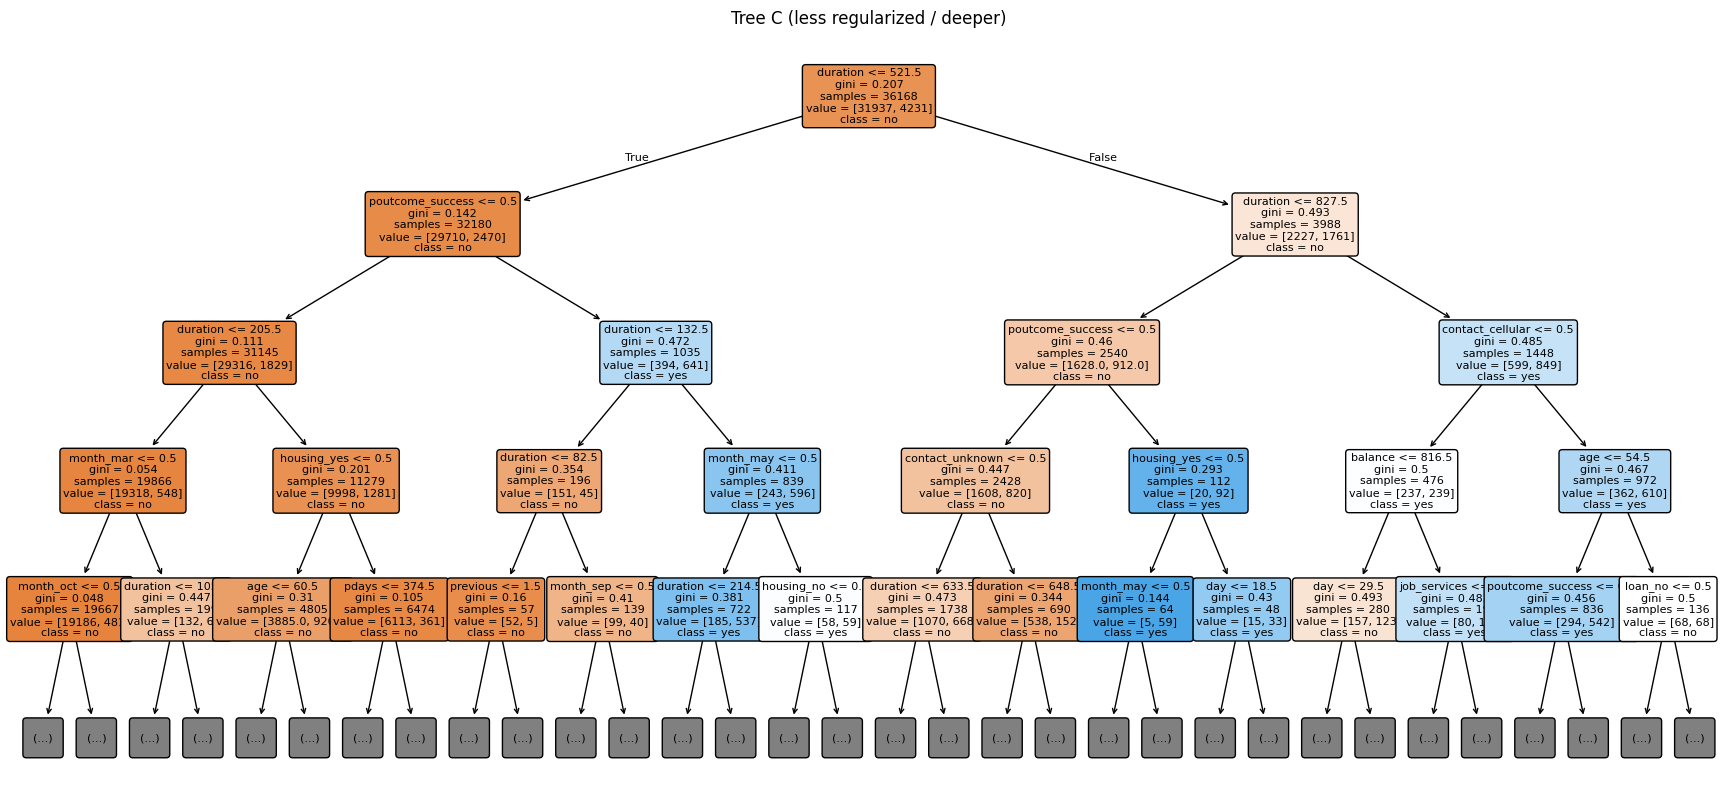

Depth: 32 | Leaves: 1608 | Nodes: 3215


In [5]:
def get_feature_names(preprocessor: ColumnTransformer) -> list[str]:
    # Build feature names from the ColumnTransformer
    ohe = preprocessor.named_transformers_["cat"]
    cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
    return cat_feature_names + num_cols

feature_names = get_feature_names(preprocess)

def plot_model_tree(pipe: Pipeline, title: str, max_depth_to_show: int | None = None):
    model = pipe.named_steps["model"]
    plt.figure(figsize=(22, 10))
    plot_tree(
        model,
        feature_names=feature_names,
        class_names=["no", "yes"],
        filled=True,
        rounded=True,
        max_depth=max_depth_to_show,
        fontsize=8,
    )
    plt.title(title)
    plt.show()
    print(f"Depth: {model.get_depth()} | Leaves: {model.get_n_leaves()} | Nodes: {model.tree_.node_count}")

for name, pipe in models.items():
    # Fit preprocess separately to extract feature names in the pipeline context
    # (Pipeline already fit, so we can access directly)
    print(f"\n=== {name} ===")
    # For readability, show only first 4 levels in the plot if the tree is very deep
    md = 4 if pipe.named_steps["model"].get_depth() > 6 else None
    plot_model_tree(pipe, title=name, max_depth_to_show=md)


### 4.1 Comments on depth & complexity

Tree A (shallow, max_depth=3)
Tree A is intentionally constrained (depth = 3), which produces a very small structure (8 leaves, 15 nodes). This makes the model highly interpretable because the decision path from root → leaf is short and uses only a few splits. The downside is that it likely underfits the data (higher bias): it cannot capture more complex interactions among features, which is consistent with its weaker ability to recover the positive class (lower recall compared to deeper trees).

Tree B (medium, max_depth=6, min_samples_leaf=20)
Tree B increases complexity (depth = 6) while also adding regularization through min_samples_leaf=20, resulting in a moderate-sized tree (54 leaves, 107 nodes). Compared to Tree A, it has more decision rules and can model more feature interactions, which generally improves its ability to detect “yes” cases (recall improves) while avoiding extreme fragmentation of the data into tiny leaves. This configuration represents a more balanced bias–variance tradeoff than Tree A or Tree C.

Tree C (deeper, min_samples_leaf=5)
Tree C is dramatically more complex (depth = 32, 1608 leaves, 3215 nodes). This indicates the model is repeatedly splitting the feature space into many small regions. While deeper trees can fit training data very closely (lower bias), they usually have higher variance and are more sensitive to noise and sampling variation, which can reduce generalization performance. The structure is far less interpretable than Tree A/B because there are too many paths and splits to follow manually.


## 5. Sensitivity analysis

What sensitivity analysis is
Sensitivity analysis evaluates how changes in input features influence a model’s output. In machine learning, this is often done by systematically varying one feature while holding other features constant and measuring how predictions change (a “one-at-a-time” / OAT approach). This type of analysis helps interpret which features drive the model’s decisions and how strongly they affect the decision boundary. OAT-style sensitivity is commonly discussed as a basic sensitivity method in uncertainty/sensitivity analysis literature (e.g., Saltelli’s lecture notes).
Citations:

Saltelli lecture notes on sensitivity analysis and OAT framing: https://www.andreasaltelli.eu/file/repository/Saltelli_Lesson_Sens_Analysis_3.pdf

scikit-learn model inspection references used here: permutation importance and partial dependence docs:
https://scikit-learn.org/stable/modules/permutation_importance.html

https://scikit-learn.org/stable/modules/partial_dependence.html

How I performed sensitivity analysis for the decision tree
I measured sensitivity for two input features: age and duration by analyzing how the model’s predicted probability changes when these features vary. Specifically:

I plotted a 2D decision surface over (age, duration) while holding all other inputs fixed at a baseline (median for numeric features and mode for categorical features). This provides a direct view of the model’s decision boundary in a 2D slice of the feature space.

I then quantified how predictions change under controlled feature changes using OAT-style perturbations and/or model inspection tools (permutation importance / partial dependence) to support interpretation.

Interpretation guide (what I expect to conclude)
If the decision boundary shifts sharply when changing duration but only slightly when changing age, that indicates the model is more sensitive to duration in determining “yes” vs “no”. Conversely, if the probability surface changes gradually with age, that indicates weaker sensitivity to age.


In [6]:
# Choose two numeric features for OAT sensitivity
# (Edit these to match what you want to analyze.)
feature_1 = "age"
feature_2 = "duration" if "duration" in num_cols else num_cols[0]

print("Using features:", feature_1, feature_2)

# We'll use the medium tree as the primary model for sensitivity
model_name = "Tree B (medium)"
pipe = models[model_name]

# Build a baseline row using medians/modes from the training set
X_base = X_train.copy()

baseline = {}
for c in cat_cols:
    baseline[c] = X_base[c].mode().iloc[0]
for c in num_cols:
    baseline[c] = float(X_base[c].median())

baseline_df = pd.DataFrame([baseline])
baseline_df[[feature_1, feature_2]].head()


Using features: age duration


,age,duration
0,39.0,180.0
